In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style(css_style = 'custom2.css')

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'


# pip install python-dotenv
# for the dotenv package, it is
# for loading personal API key, as we'll 
# see, but you don't have to use it
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from subprocess import call
from dotenv import load_dotenv
from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from sklearn.metrics import mean_squared_error
from sklearn.metrics import pairwise_distances

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,sklearn,requests

Ethen 2017-10-10 17:26:46 

CPython 3.5.2
IPython 6.1.0

numpy 1.13.3
pandas 0.20.3
matplotlib 2.0.0
sklearn 0.19.0
requests 2.18.4


# Alternating Least Squares with Weighted Regularization

Recommedantion system is a popular topic in recent years, what is does (or its goal) is to seek to predict the "rating" or "preference" that a user would give to an item. Given the rating, the business will then recommend preferable new items to the user for further purchases. The type of recommendation system that we will be discussing is known as **collaborative filtering**, where the features of the user (e.g. age, gender) or the item (e.g. perishable or not) itself do not play any role in the algorithm. Instead, we rely soley on the ratings that a user gave to the item.

We start by loading some sample data to make this a bit more concrete. For this introduction, we'll be using the [MovieLens dataset](http://grouplens.org/datasets/movielens/). The website has datasets of various sizes, but we just start with the smallest one [MovieLens 100K Dataset](http://files.grouplens.org/datasets/movielens/ml-100k.zip). This dataset consists of 100,000 movie ratings by users (on a 1-5 scale). The main data set `u.data` file consists of four columns (tab-delimited), including user-id (starting at 1), item-id (starting at 1), rating, and timestamp (we won't be using this field).

In [3]:
# download the dataset if it isn't in the same folder
file_dir = 'ml-100k'
file_path = os.path.join(file_dir, 'u.data')
if not os.path.isdir(file_dir):
    call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'])
    call(['unzip', 'ml-100k.zip'])

names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(file_path, sep = '\t', names = names)
print(df.shape)
df.head()

(100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


As we can see, the only data that we have is how each user interacted or rated each item. Given this information, collaborative filtering will start by constructing a user-item matrix with each distinct user being the row, item being the column and the value for each cell will simply be the rating that the user gave to the item. Apart from building the matrix, we will also print out some other information to help us understand our data a bit better.

In [4]:
# create the rating matrix r_{ui}, remember to
# subract the user and item id by 1 since
# the indices starts from 0
n_users = df['user_id'].unique().shape[0]
n_items = df['item_id'].unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples(index = False):
    ratings[row.user_id - 1, row.item_id - 1] = row.rating

# compute the non-zero elements in the rating matrix
matrix_size = np.prod(ratings.shape)
interaction = np.flatnonzero(ratings).shape[0]
sparsity = 100 * (interaction / matrix_size)

print('dimension: ', ratings.shape)
print('sparsity: {:.1f}%'.format(sparsity))
ratings

dimension:  (943, 1682)
sparsity: 6.3%


array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

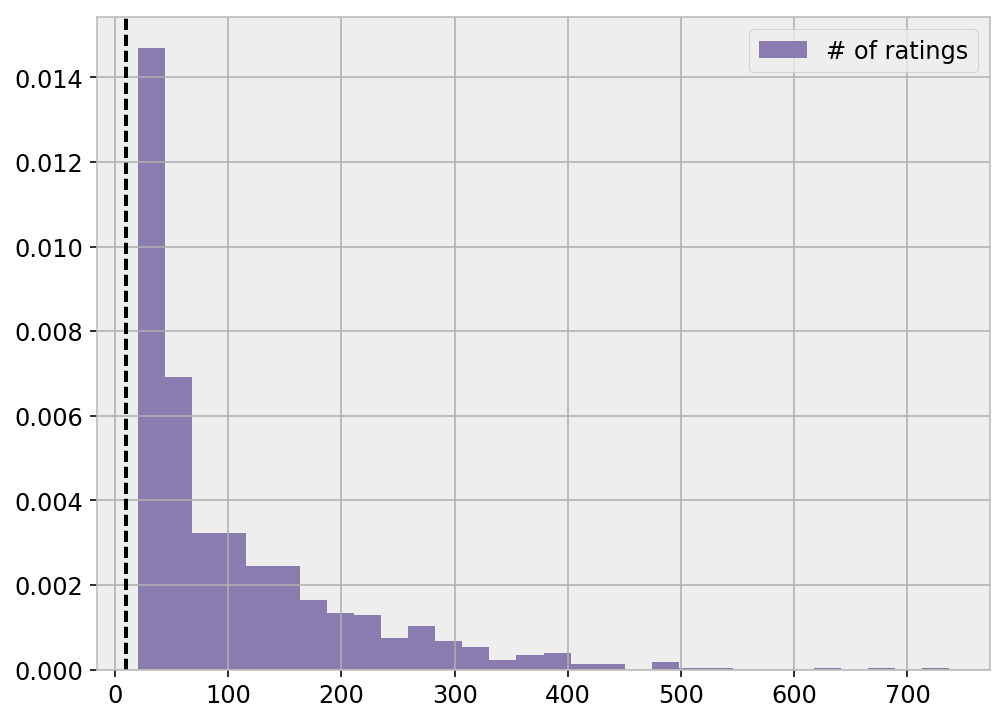

In [5]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

plt.hist(np.sum(ratings != 0, axis = 1), histtype = 'stepfilled', bins = 30,
         alpha = 0.85, label = '# of ratings', color = '#7A68A6', normed = True)
plt.axvline(x = 10, color = 'black', linestyle = '--')
plt.legend(loc = "upper right")
plt.show()

From the information above, we know there are 943 unique users, 1682 unique items. Within the rating matrix, only 6.3% of the cells have a value, although we filled in empty ratings as 0, we should not assume these values to truly be zero. More appropriately, they are just missing entries. This kind of sparsity is extremely common in recommendation system, where people seldom give ratings to things that they have purchased. One thing to note is that if the sparsity of the matrix is below 1% (rule of thumb), then the dataset might be too sparse to perform any sort of modeling.

Next the histogram tells us that every user has given at least more than 10 ratings, we will use this to perform the train/test split of the data for testing the algorithm that we'll build later.

One tricky thing about splitting the data into training and testing is that: In supervise machine learning we normally build the trainining and testing holdout set by randomly splitting the rows. In those cases, this idea works, because we have a model with features/target that we are trying to fit a function to. For recommender systems with collaborative filtering (no features), this just won't work anymore, because all of the items/users need to be available when the model is first built. So what we do instead is mask a random sample of the user/item ratings to validate and compare how well the recommender system did in predicting the ratings of those masked values. In our case, given we already know each user has given more than 10 ratings, what we'll do is for every user, we remove 10 of the item ratings and and assign them to the test set. The testing matrix is printed below, as hopefully, you can see that some of the values are indeed different from the original rating matrix.

In [6]:
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size = 10, replace = False)

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test

train, test = create_train_test(ratings)
del ratings
train

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

## Matrix Factorization

Now that the data preprocessing part has been taken care of, let's get to the more exciting part, the algorithm. The algorithm that we'll introduce today is Matrix Factorization.

Recall that we had a user-item matrix, $R$ where nonzero elements of the matrix are ratings that a user has given an item. What Matrix Factorization does is it decomposes a large matrix into products of matrices, namely, $R = U \times V$. See the picture below taken from a quick [google search](https://www.google.com/search?q=matrix+factorization&source=lnms&tbm=isch&sa=X&ved=0ahUKEwiD8Ku02_vQAhXGsVQKHdpSAW4Q_AUICCgB&biw=1433&bih=732#imgrc=aFtUeC0wtJCkgM%3A) for a better understanding:

![](img/matrix_factorization.png)

Matrix factorization assumes that:

- Each user can be described by $d$ features. For example, feature 1 might be a referring to how much each user likes disney movies.
- Each item, movie in this case, can be described by an analagous set of $d$ features. To correspond to the above example, feature 1 for the movie might be a number that says how close the movie is to a disney movie.

After learning the two smaller matrices, all we have to do is to perform a matrix multiplication of the two matrices and the end result will be a our approximation for the rating the user would give that item (movie).

The cool thing about this is that, we do not know what these features are nor do we have to determine them beforehand, which is why these features are often refer to as latent features. Next, we also don't know how many latent features are optimal for the task at hand. Thus, we simply have to use random search or grid search or other fancy techniques to perform hyperparameter tuning and determine the best number for $d$. 

Given all those information, the next question is: how do we learn the user matrix, $U$, and item matrix, $V$? Well, like a lot of machine learning algorithm, by minimizing a loss function.

We start by denoting our $d$ feature user into math by letting a user $u$ take the form of a $1 \times d$-dimensional vector $\textbf{x}_{u}$. These for often times referred to as latent vectors or low-dimensional embeddings. Similarly, an item *i* can be represented by a $1 \times d$-dimensional vector $\textbf{y}_{i}$. And the rating that we predict user $u$ will give for item $i$ is just the dot product of the two vectors

\begin{align}
\hat r_{ui} &= \textbf{x}_{u} \textbf{y}_{i}^{T} = \sum\limits_{d} x_{ud}y_{di}
\end{align}

Where $\hat r_{ui}$ represents our prediction for the true rating $r_{ui}$. Next, we will choose a objective function to minimize the square of the difference between all ratings in our dataset ($S$) and our predictions. This produces a objective function of the form:

\begin{align}
L &= \sum\limits_{u,i \in S}( r_{ui} - \textbf{x}_{u} \textbf{y}_{i}^{T} )^{2} + \lambda \big( \sum\limits_{u} \left\Vert \textbf{x}_{u} \right\Vert^{2} + \sum\limits_{i} \left\Vert \textbf{y}_{i} \right\Vert^{2} \big)
\end{align}

Note that we've added on two $L_{2}$ regularization terms, with $\lambda$ controlling the strength at the end to prevent overfitting of the user and item vectors. $\lambda$, is another hyperparameter that we'll have to search for to determine the best value. The concept of regularization can be a topic of itself, and if you're confused by this, consider checking out [this documentation](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/regularization/regularization.ipynb) that covers it a bit more.

Now that we formalize our objective function, we'll introduce the **Alternating Least Squares with Weighted Regularization (ALS-WR)** method for optimizing it. The way it works is we start by treating one set of latent vectors as constant. For this example, we'll pick the item vectors, $\textbf{y}_{i}$. We then take the derivative of the loss function with respect to the other set of vectors, the user vectors, $\textbf{x}_{u}$ and solve for the non-constant vectors (the user vectors).

\begin{align}
\frac{\partial L}{\partial \textbf{x}_{u}} 
&\implies - 2 \sum\limits_{i}(r_{ui} - \textbf{x}_{u} \textbf{y}_{i}^{T} ) \textbf{y}_{i} + 2 \lambda \textbf{x}_{u} = 0 \\
&\implies -(\textbf{r}_{u} - \textbf{x}_{u} Y^{T} )Y + \lambda \textbf{x}_{u} = 0 \\
&\implies \textbf{x}_{u} (Y^{T}Y + \lambda I) = \textbf{r}_{u}Y \\
&\implies \textbf{x}_{u} = \textbf{r}_{u}Y (Y^{T}Y + \lambda I)^{-1}
\end{align}

To clarify it a bit, let us assume that we have $m$ users and $n$ items, so our ratings matrix is $m \times n$.

- The row vector $\textbf{r}_{u}$ represents users *u*'s row from the ratings matrix with all the ratings for all the items (so it has dimension $1 \times n$)
-  We introduce the symbol $Y$, with dimensions $n \times d$, to represent all item row vectors vertically stacked on each other
- Lastly, $I$ is the identity matrix which has dimension $d \times d$ to ensure the matrix multiplication's dimensionality will be correct when we add the $\lambda$

Now comes the alternating part: With these newly updated user vectors in hand, in the next round, we hold them as constant, and take the derivative of the loss function with respect to the previously constant vectors (the item vectors). As the derivation for the item vectors is quite similar, we will simply list out the end formula:

\begin{align}
\frac{\partial L}{\partial \textbf{y}_{i}}
&\implies \textbf{y}_{i} = \textbf{r}_{i}X (X^{T}X + \lambda I)^{-1}
\end{align}

Then we alternate back and forth and carry out this two-step process until convergence. The reason we alternate is, optimizing user latent vectors, $U$, and item latent vectors $V$ simultaneously is hard to solve. If we fix $U$ or $V$ and tackle one problem at a time, we potentially turn it into a easier sub-problem. Just to summarize it, ALS works by:

1. Initialize the user latent vectors, $U$, and item latent vectors $V$ with randomly
2. Fix $U$ and solve for $V$
3. Fix $V$ and solve for $U$
4. Repeat step 2 and 3 until convergence

Now that we have our equations, let's program this thing up! We'll set the model to use 20 factors and a regularization value of 0.01 (chosen at random) and train it for 100 iterations and compute the mean square error on the train and test set to assess algorithm convergence.

In [7]:
class ExplicitMF:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    n_factors : int
        number of latent factors to use in matrix 
        factorization model, some machine-learning libraries
        denote this as rank
        
    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors  
        
    def fit(self, train, test):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
        
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_mse_record  = []
        self.train_mse_record = []   
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors) 
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)
        
        return self    
    
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse

In [8]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_mse_record, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc = 'best')

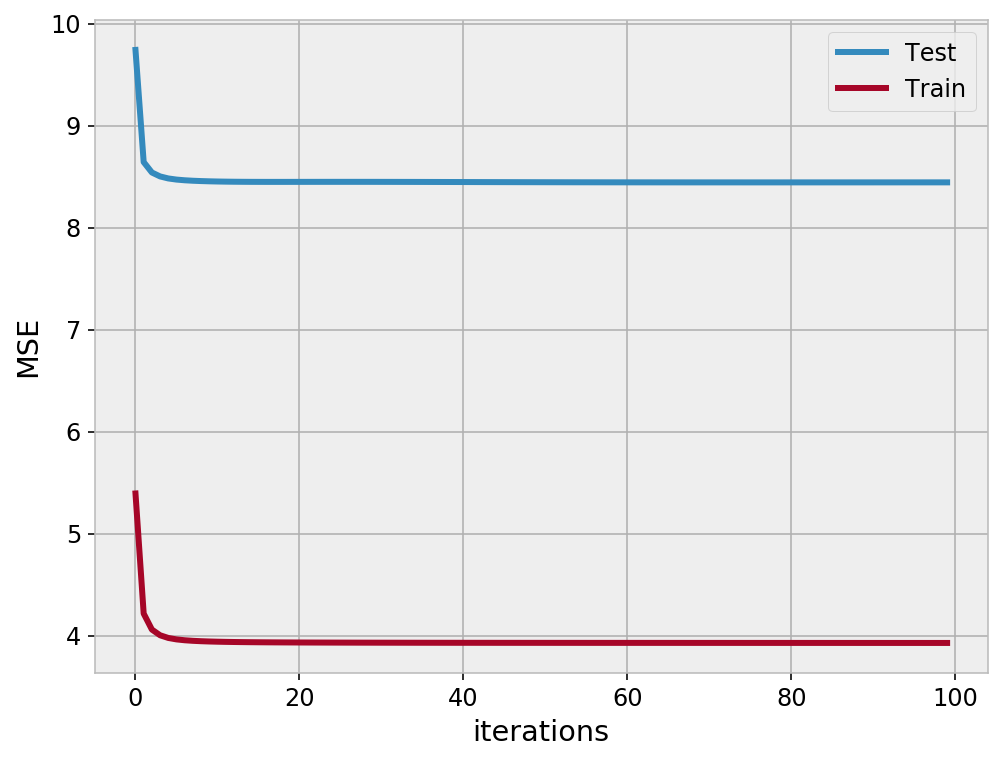

In [9]:
als = ExplicitMF(n_iters = 100, n_factors = 40, reg = 0.01)
als.fit(train, test)
plot_learning_curve(als)

From the result, we can see ALS converges after a few sweeps, which is one of the main reason for its popularity. Fast, thus scalable to bigger dataset.

## Validating the Recommendation

After training our model, we'll actually look at the recommended result to see if our recommendation algorithm is any good or not. The way we do this is: The MovieLens dataset contains a file called `u.item` with information about each movie. To put the cherry on top, it turns out that there is a website called [themoviedb.org](http://www.themoviedb.org) which has a free API. If we have the IMDB "movie id" for a movie, then we can use this API to retrieve the movie's corresponding poster. Note that you will have to sign up and request for an API key if you wish to reproduce the example below.

In [16]:
# Load in movies' information, stored in the u.item (pipe delimited)
# file, the first element is the id, and the fourth element is the 
# movie's IMDB url
idx_to_movie = {}
item_path = os.path.join(file_dir, 'u.item')

with open(item_path, encoding = 'latin1') as f:
    for line in f.readlines():
        info = line.split('|')
        idx = int(info[0]) - 1
        movie = info[4]
        idx_to_movie[idx] = movie
        
idx_to_movie[1]

'http://us.imdb.com/M/title-exact?GoldenEye%20(1995)'

For example, if we paste the sample url above into our browser, then our url will get redirected. The resulting url contains the IMDB movie ID as the last information in the url starting with "tt". For example, the redirected url for Toy Story is http://www.imdb.com/title/tt0114709/, and the corresponding IMDB movie ID is therefore tt0114709.

In [11]:
# stripping the movie id with requests
response = requests.get(idx_to_movie[0])
movie_id = response.url.split('/')[-2]
print(movie_id)

www.imdb.com


In [15]:
response = requests.get(idx_to_movie[0])
response.url

'http://www.imdb.com/find?q=opfrule=httpDefault%26Toy%20Story&s=tt'

From the API documentation: 

To build an image URL, we will need 3 pieces of data. The base_url, size and file_path, after combining all of them all, we will have a fully qualified URL. Here’s an example URL: 
https://image.tmdb.org/t/p/w500/8uO0gUM8aNqYLs1OsTBQiXu0fEv.jpg

So to get the base_url, we send a request to the https://api.themoviedb.org/3/configuration using our API key as the parameter, after that we load the information into a dictionary and access the `base_url` key under the `images` key (the base_url is nested under images), and we'll also append the poster size at the end of the base_url.

In [12]:
# here I'm simply loading my API key
# from a .env file, and using dotenv package
# to obtain the value of the variable, you may
# simply change the api_key variable to your key
load_dotenv('.env')
api_key = os.environ.get('API_KEY')

# request the base_url
params = {'api_key': api_key}
response = requests.get('http://api.themoviedb.org/3/configuration', params = params)

# for the poster there are different sizes
# 'w92', 'w154', 'w185', 'w342', 'w500', 'w780', 'original',
# simply change it to the one you prefer
base_url = json.loads(response.text)['images']['base_url'] + 'w185'
base_url

'http://image.tmdb.org/t/p/w185'

Next to get the file_path to the poster image, we have to send another request to http://api.themoviedb.org/3/movie/{}/images, where we have to fill in the movie_id for {}. Then the actual path will be stored under the `file_path` key under the `posters` key (accessing the posters key will give you a list of path, we'll simply use the first one).

In [13]:
image_url = 'http://api.themoviedb.org/3/movie/{}/images'.format(movie_id)
response  = requests.get(image_url, params = params)
file_path = json.loads(response.text)['posters'][0]['file_path']
file_path

KeyError: 'posters'

In [14]:
json.loads(response.text)

{'status_code': 34,
 'status_message': 'The resource you requested could not be found.'}

After that we can simply concatenate the base_url and the file path and display the poster image.

In [ ]:
full_path = base_url + file_path
Image(full_path)

Unfortunately, there are also other edge-cases, where we have to search for the title and grab the poster image there. e.g.

In [ ]:
movie_url = 'http://us.imdb.com/M/title-exact?Fox%20and%20the%20Hound,%20The%20(1981)'
response = requests.get(movie_url)

# see how the url is different this time,
# we have to strip out the title between the = sign
# and pass it to the movie search API using the title
# as a query parameter
print(response.url)
query = response.url.split('=')[-2]
params['query'] = query
response = requests.get('http://api.themoviedb.org/3/search/movie', params = params)
json.loads(response.text)
file_path = json.loads(response.text)['results'][0]['poster_path']
full_path = base_url + file_path
Image(full_path)

In the following section, we'll train the model again, use [themoviedb.org](http://www.themoviedb.org)'s API to grab the movie posters and visualize the top 5 most similar movies (measured by cosine distance) for some input movie. These similar movies will serve as our recommendation for a given input movie.

Side note, the images are displayed using HTML so multiple images can be displayed in one line, idea taken from this [Stackoverflow question](http://stackoverflow.com/questions/19471814/display-multiple-images-in-one-ipython-notebook-cell/27795087#27795087).

In [ ]:
class Recommendation:
    """
    Train the ALS model to be able to
    recommend the top-k similar movies for a given query
    
    Parameters
    ----------
    k: int
        number of top similar movies to recommend for
        a given query
        
    model: ExplicitMF
        the recommendation algorithm
        
    idx_to_movie: dict
        a dictionary mapping movie id to their imdb url
    """

    def __init__(self, model, k, idx_to_movie):
        self.k = k
        self.model = model
        self.idx_to_movie = idx_to_movie
         
    def fit(self, train, test):
        # train the model and compute the pairwise cosine distance
        self.model.fit(train, test)
        self.sim_mat = pairwise_distances(self.model.item_factors, metric = 'cosine')
        
        # also get the base url for the API
        # assuming API key is stored in .env file
        load_dotenv('.env')
        api_key = os.environ.get('API_KEY')
        self.params = {'api_key': api_key}
        response = requests.get('http://api.themoviedb.org/3/configuration', 
                                params = self.params)
        self.base_url = json.loads(response.text)['images']['base_url'] + 'w185'
        return self
    
    def recommend(self, query):
        movie_url = idx_to_movie[query]
        input_poster = self._get_poster(movie_url)
        input_image = '<img src={} />'.format(input_poster)
        recommended_images = self._get_top_k_recommendation(query)
        
        # display query movie and for that movie top-k recommendations
        display(HTML('<font size=5> Input </font>'))
        input_image = '<img src={} />'.format(input_poster)
        display(HTML(input_image))
        display(HTML('<font size=5> Recommendation </font>'))
        display(HTML(recommended_images))

    def _get_poster(self, movie_url):
        """get the poster image for a given movie url"""
        try:
            response = requests.get(movie_url)
            movie_id = response.url.split('/')[-2]
            image_url = 'http://api.themoviedb.org/3/movie/{}/images'.format(movie_id)
            response = requests.get(image_url, params = self.params)
            file_path = json.loads(response.text)['posters'][0]['file_path']
        except KeyError:
            try:
                response = requests.get(movie_url)
                query = response.url.split('=')[-2]
                self.params['query'] = query
                response = requests.get(
                    'http://api.themoviedb.org/3/search/movie', params = self.params)
                json.loads(response.text)
                file_path = json.loads(response.text)['results'][0]['poster_path']
                self.params.pop('query')
            except KeyError:
                # sometimes the url just doesn't work
                # return an empty string to not mess up the display
                file_path = ''

        full_path = self.base_url + file_path
        return full_path
    
    def _get_top_k_recommendation(self, query):
        """
        sort the similarity vector to get the most similar,
        remember the smaller the cosine, the more similar they are
        but the query item itself will always be the most similar,
        so exclude that from the output
        """
        sim = self.sim_mat[query]
        top_k_item_idx = np.argsort(sim)[1:self.k + 1]
        recommended_images = ''
        for item_idx in top_k_item_idx:
            movie_url = self.idx_to_movie[item_idx]
            recommended_poster = self._get_poster(movie_url)
            recommended_images += """
                                  <img style='width: 150px; height: 250px; margin: 0px;
                                              float: left; border: 1px solid black;' 
                                       src={} />
                                  """.format(recommended_poster)
        return recommended_images

In [ ]:
als = ExplicitMF(n_iters = 100, n_factors = 40, reg = 0.01)
recsys = Recommendation(model = als, k = 5, idx_to_movie = idx_to_movie)
recsys = recsys.fit(train, test)

In [ ]:
query = 1
recsys.recommend(query)

In [ ]:
query = 500
recsys.recommend(query)

I'll leave it up to you to determine whether these recommendations are good or not (results will slightly differ across different runs). In practice A/B testing is most likely a better way to judge whether these recommendations are useful, but that's a topic for some other day.

# Reference

- [Blog: Intro to Recommender Systems: Collaborative Filtering](http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/)
- [Blog: Explicit Matrix Factorization: ALS, SGD, and All That Jazz](http://blog.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/)
- [Quora: What is the Alternating Least Squares method in recommendation systems?](https://www.quora.com/What-is-the-Alternating-Least-Squares-method-in-recommendation-systems)